In [31]:
import sys
sys.path.append("./../../src")
import pandas as pd
import numpy as np

import torch
from torch import nn, optim
import pickle

In [13]:
from vae_with_dataloader import VAE, VAETrainerWithDataLoader
from icd_analysis_helper import ICDAnalysisHelper
from dataloader import MixehrICDImputationDataset
from visualizer_helper import Visualizer

from config_reader import Config
import os
import math
from sklearn.model_selection import train_test_split

In [3]:
###Load Configuration file
config = Config('./config.ini')
experiment_name=config.experiment_name
config.__dict__

{'patient_icd_path': '/data1/andrew/meng/mixehr/data/Mimic/andrew_outputs/PATIENT_ICD_BINARY.csv',
 'icd9codes_path': '/data1/andrew/meng/mixehr/data/Mimic/mimic-iii-clinical-database-1.4/D_ICD_DIAGNOSES.csv.gz',
 'subject_ids_path': '/Users/andrew/Documents/meng/spring/PATIENT_ICD_SUBJECT_IDS.csv',
 'experiment_name': '200211_mixehr_imputation_icd9codes',
 'encoder_dim': [(250, 500), (500, 250), (250, 100)],
 'latent_dim': 25,
 'decoder_dim': [(250, 500), (500, 250), (250, 100)],
 'use_relu_encoder': True,
 'use_relu_decoder': True,
 'kld_beta': 1.0}

In [4]:
###Load Matrices
# metaphe_path = "/Users/andrew/Documents/meng/mixEHR/data/precomputed_results/mixmimic/mimic_trainData_mimic_trainData_JCVB0_nmar_K75_iter5497_metaphe.csv"
metaphe_path = "/data1/andrew/meng/mixehr/data/precomputed_results/mixmimic/mimic_trainData_mimic_trainData_JCVB0_nmar_K75_iter5497_metaphe.csv"
icd_topic_distribution_path = "../../mixehr_analysis/imputed_data/mixehr_topics_normalized_FROM_ICD_DISTRIBUTION_with_phenames_icd_only.csv"

mixehr_icd_imputation_dataset = MixehrICDImputationDataset(patient_topic_distribution_path = metaphe_path, 
                                                           icd_topic_feature_distribution_path = icd_topic_distribution_path)

In [5]:
params = {'batch_size': 64,
          'shuffle': True}

mixehr_training_generator = torch.utils.data.DataLoader(mixehr_icd_imputation_dataset, **params)

In [6]:
###Load Model
print("Feature_dim: {}".format(mixehr_icd_imputation_dataset.get_feat_dim()))
model = VAE(
    feature_dim = mixehr_icd_imputation_dataset.get_feat_dim(),
    encoder_dim = config.encoder_dim,
    latent_dim = config.latent_dim,
    decoder_dim = config.decoder_dim,
    use_relu_encoder= config.use_relu_encoder,
    use_relu_decoder= config.use_relu_decoder
)

model = model.double()

optimizer = optim.Adam(model.parameters(), lr=0.001)
print(type(optimizer))

Feature_dim: 7985
<class 'torch.optim.adam.Adam'>


In [7]:
###Load Trainer
trainer = VAETrainerWithDataLoader(
    model=model, 
    optimizer=optimizer,
    experiment_name=experiment_name,
    kld_beta=config.kld_beta
)

In [ ]:
###Train Model
trainer.train(
    training_generator=mixehr_training_generator,
    validation_generator=None,
    epochs=80,
    batch_size=40,
    save_model_interval=5,
    clip_gradients=False
)

In [ ]:
trainer.plot_elbo()
trainer.plot_bce()
trainer.plot_kld()

In [ ]:
# icd9codes = pd.read_csv(config.icd9codes_path)
# icd_analyzer = ICDAnalysisHelper(icd9codes_df = icd9codes, patient_icd_df = patient_icd_df)
# #icd_analyzer.lookup_icds(icd9codes, ["4019", "41401"])

In [8]:
##Load pre-trained model
epoch = 10
model.load_state_dict(torch.load("./VAE_exp_{}_epoch_{}.pkl".format(experiment_name, epoch)))
trainer.model = model

In [9]:
###Encode data
encoding_params = {'batch_size': 64, 'shuffle': False}
mixehr_encoding_generator = torch.utils.data.DataLoader(mixehr_icd_imputation_dataset, **encoding_params)

latent, means, var = trainer.encode_data(mixehr_encoding_generator)

In [12]:
print(latent.shape, means.shape, var.shape)

torch.Size([38071, 25]) torch.Size([38071, 25]) torch.Size([38071, 25])


In [26]:
visualizer = Visualizer()

###Plot UMAP representations
X_umap = visualizer.umap_embedding(latent.cpu().detach().numpy())
mean_umap = visualizer.umap_embedding(means.cpu().detach().numpy())
var_umap = visualizer.umap_embedding(var.cpu().detach().numpy())

In [32]:
pickle.dump(X_umap, open("X_umap.p", 'wb'))
pickle.dump(mean_umap, open("mean_umap.p", 'wb'))
pickle.dump(var_umap, open("var_umap.p", 'wb'))

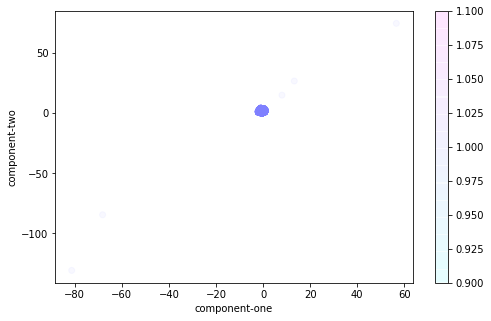

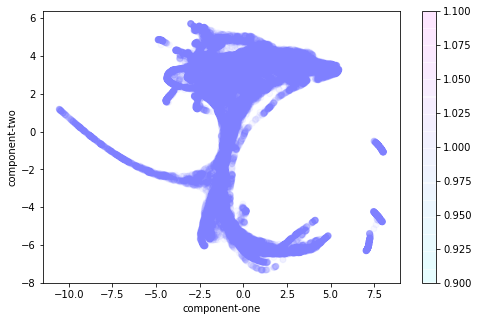

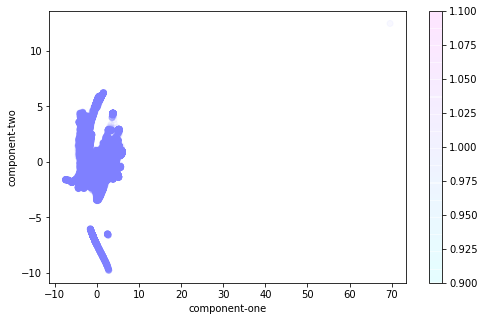

In [27]:
visualizer.plot2d(
    X=X_umap, 
    filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone"), 
    colors=[1 for i in range(X_umap.shape[0])],
)

visualizer.plot2d(
    X=mean_umap, 
    filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_means"), 
    colors=[1 for i in range(X_umap.shape[0])],
)

visualizer.plot2d(
    X=var_umap, 
    filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_vars"), 
    colors=[1 for i in range(X_umap.shape[0])],
)

In [28]:
X_umap_3d = visualizer.umap_embedding(latent.cpu().detach().numpy(), n_components=3)
mean_umap_3d = visualizer.umap_embedding(means.cpu().detach().numpy(), n_components=3)
var_umap_3d = visualizer.umap_embedding(var.cpu().detach().numpy(), n_components=3)

In [33]:
pickle.dump(X_umap_3d, open("X_umap_3d.p", 'wb'))
pickle.dump(mean_umap_3d, open("mean_umap_3d.p", 'wb'))
pickle.dump(var_umap_3d, open("var_umap_3d.p", 'wb'))

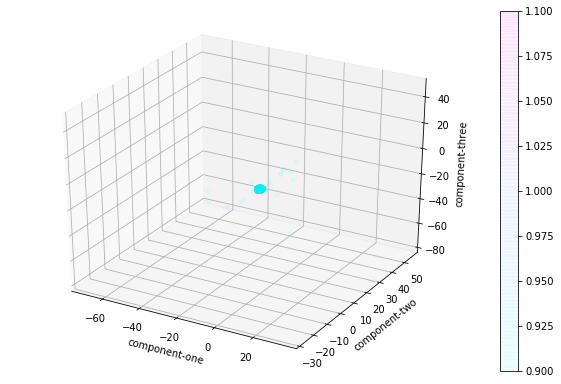

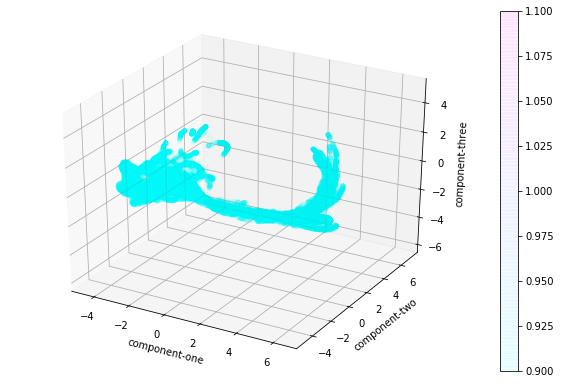

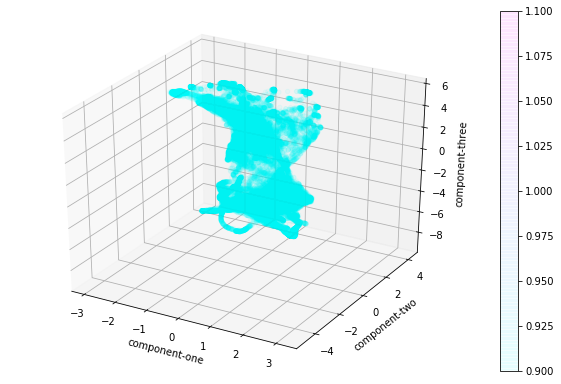

In [29]:
visualizer.plot3d(
    X=X_umap_3d, 
    filename="Patient_Clusters_3D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone"), 
    colors=[1 for i in range(X_umap_3d.shape[0])],
)

visualizer.plot3d(
    X=mean_umap_3d, 
    filename="Patient_Clusters_3D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_means"), 
    colors=[1 for i in range(X_umap_3d.shape[0])],
)

visualizer.plot3d(
    X=var_umap_3d, 
    filename="Patient_Clusters_3D_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_everyone_vars"), 
    colors=[1 for i in range(X_umap_3d.shape[0])],
)

In [ ]:
# ###Additional Visualizations
# baby_keywords = ['congenital', 'infant', 'newborn', 'neonatal', 'born', 'birth']
# heart_keywords = ['heart', 'atrial', 'coronary', 'hypertension', 'vascular']


# heart_patient_idxs_tr = icd_analyzer.get_patients_idxs_with_disease_keywords(patient_df=train_df, 
#                                                                              substrings=heart_keywords, 
#                                                                              case_sensitive=False
#                                                                             )
# baby_patient_idxs_tr = icd_analyzer.get_patients_idxs_with_disease_keywords(patient_df=train_df,
#                                                                             substrings=baby_keywords,
#                                                                             case_sensitive=False
#                                                                            )

# baby_heart_colors_tr = np.array([0 for i in range(X_umap_tr.shape[0])])
# baby_heart_colors_tr[heart_patient_idxs_tr] = 100
# baby_heart_colors_tr[baby_patient_idxs_tr] = 50

# visualizer.plot2d(
#     X=X_umap_tr, 
#     filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_baby_heart_umap_train"), 
#     colors=baby_heart_colors_tr)


# heart_patient_idxs_val = icd_analyzer.get_patients_idxs_with_disease_keywords(patient_df=val_df, 
#                                                                               substrings=heart_keywords,
#                                                                               case_sensitive=False)
# baby_patient_idxs_val = icd_analyzer.get_patients_idxs_with_disease_keywords(patient_df=val_df,
#                                                                              substrings=baby_keywords,
#                                                                              case_sensitive=False)

# baby_heart_colors_val = np.array([0 for i in range(X_umap_val.shape[0])])
# baby_heart_colors_val[heart_patient_idxs_val] = 100
# baby_heart_colors_val[baby_patient_idxs_val] = 50
# visualizer.plot2d(
#     X=X_umap_val, 
#     filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_baby_heart_umap_val"), 
#     colors=baby_heart_colors_val)

In [ ]:
# X_umap_3d_tr = visualizer.umap_embedding(latent_train.cpu().detach().numpy(), n_components=3)

# visualizer.plot3d(
#     X=X_umap_3d_tr, 
#     filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_heart_umap_3D_train"), 
#     colors=baby_heart_colors_tr,
# )

In [ ]:
# ###Plot UMAP representations
# heart_patient_idxs = icd_analyzer.get_patients_idxs_with_disease_keywords(substrings=heart_keywords, case_sensitive=False)
# heart_colors = np.array([0 for i in range(X_umap.shape[0])])
# heart_colors[heart_patient_idxs] = 100

# visualizer.plot2d(
#     X=X_umap_tr, 
#     filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_heart_umap_train"), 
#     colors=heart_colors,
# )
# visualizer.plot2d(
#     X=X_umap_means_tr, 
#     filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_heart_umap_means_train"), 
#     colors=heart_colors,
# )
# visualizer.plot2d(
#     X=X_umap_vars_tr, 
#     filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_heart_umap_vars_train"), 
#     colors=heart_colors,
# )